In [34]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold,StratifiedKFold,train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier
import os
import eli5
from eli5.sklearn import PermutationImportance
from catboost import CatBoostClassifier
import warnings
warnings.filterwarnings('ignore')

In [35]:
train_df=pd.read_csv('../input/av-janatahack-crosssell-prediction/train.csv')
test_df=pd.read_csv('../input/av-janatahack-crosssell-prediction/test.csv')
submission_df=pd.read_csv('../input/av-janatahack-crosssell-prediction/sample_submission_iA3afxn.csv')

In [36]:
train_df.head(5)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


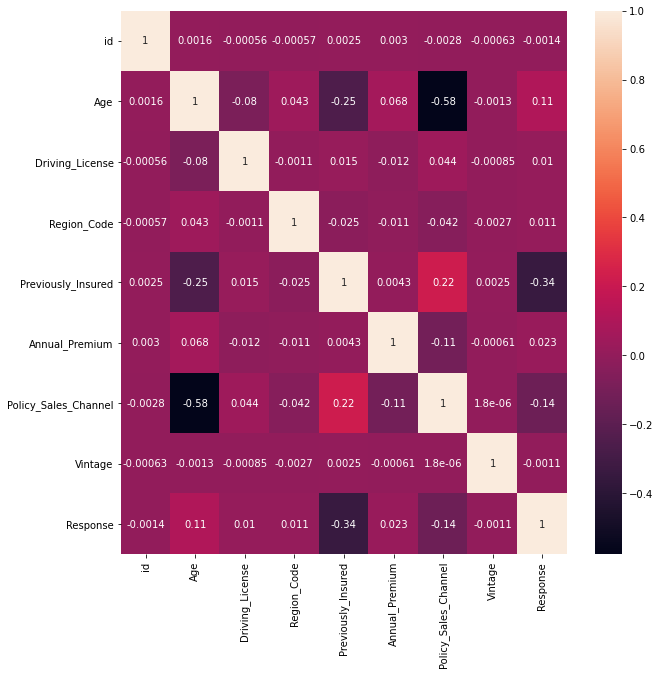

In [39]:
plt.figure(figsize=(10,10))
sns.heatmap(train_df.corr(),annot=True)

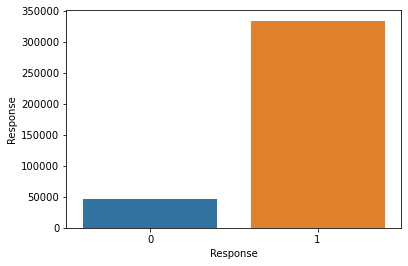

In [40]:
sns.barplot(train_df['Response'],train_df['Response'].value_counts())

In [41]:
train_df=train_df.drop_duplicates(subset=[ele for ele in list(train_df.columns) if ele not in ['id']])
combine_set=pd.concat([train_df,test_df])

In [42]:
#Analysis show that people in Age Group 30-60 have higher response rate so creating a separate feature
combine_set['Age_Group'] = np.where((combine_set['Age']<30) & (combine_set['Age'] > 60),0,1)

In [43]:

def find_non_rare_labels(df, variable, tolerance):
    
    temp = df.groupby([variable])[variable].count() / len(df)
    
    non_rare = [x for x in temp.loc[temp>tolerance].index.values]
    
    return non_rare

def rare_encoding(data, variable, tolerance,new_col):
    frequent_cat = find_non_rare_labels(data, variable, tolerance)

    # re-group rare labels
    data[new_col] = np.where(data[variable].isin(
        frequent_cat), data[variable], -1)



for variable in ['Policy_Sales_Channel']:
    
     rare_encoding(combine_set, variable, 0.01,'Policy_Sales_Channel_Group')
        
for variable in ['Region_Code']:
    
     rare_encoding(combine_set, variable, 0.02,'Region_Code_Group')

In [44]:
#Feature Engineering

le=LabelEncoder()
combine_set['Gender']=le.fit_transform(combine_set['Gender'])
combine_set['Vehicle_Damage']=le.fit_transform(combine_set['Vehicle_Damage'])
combine_set['Vehicle_Age']=combine_set['Vehicle_Age'].map({'< 1 Year':0,'1-2 Year':1,'> 2 Years':2})

combine_set['Customer_term_in_year']=combine_set['Vintage']/365
combine_set['Total_premium_Channelwise']=combine_set.groupby(['Policy_Sales_Channel'])['Annual_Premium'].transform('sum')
combine_set['Mean_premium_Channelwise']=combine_set.groupby(['Policy_Sales_Channel'])['Annual_Premium'].transform('mean')
combine_set['Maximum_premium_Channelwise']=combine_set.groupby(['Policy_Sales_Channel'])['Annual_Premium'].transform('max')
combine_set['Min_premium_Channelwise']=combine_set.groupby(['Policy_Sales_Channel'])['Annual_Premium'].transform('min')
combine_set['Total_premium_regionwise']=combine_set.groupby(['Region_Code'])['Annual_Premium'].transform('sum')
combine_set['Mean_premium_regionwise']=combine_set.groupby(['Region_Code'])['Annual_Premium'].transform('mean')
combine_set['Max_premium_regionwise']=combine_set.groupby(['Region_Code'])['Annual_Premium'].transform('max')
combine_set['Min_premium_regionwise']=combine_set.groupby(['Region_Code'])['Annual_Premium'].transform('min')
combine_set['Age_groups_region_wise']=combine_set.groupby(['Region_Code'])['Age'].transform('nunique')
combine_set['regionwise_channels']=combine_set.groupby(['Policy_Sales_Channel'])['Region_Code'].transform('nunique')
combine_set['Channelwise_regions']=combine_set.groupby(['Region_Code'])['Policy_Sales_Channel'].transform('nunique')
combine_set['Unique_customers_based_Vinatge']=combine_set.groupby(['Region_Code','Policy_Sales_Channel'])['Vintage'].transform('nunique')
combine_set['Region_wise_Vehicle_Age_premium']=combine_set.groupby(['Region_Code','Vehicle_Age'])['Annual_Premium'].transform('sum')
combine_set['Region_wise_Vehicle_Age_premium_mean']=combine_set.groupby(['Region_Code','Vehicle_Age'])['Annual_Premium'].transform('mean')
combine_set['Region_wise_Vehicle_Age_premium_max']=combine_set.groupby(['Region_Code','Vehicle_Age'])['Annual_Premium'].transform('max')
combine_set['Channel_wise_Vehicle_Age_premium']=combine_set.groupby(['Policy_Sales_Channel', 'Vehicle_Age'])['Annual_Premium'].transform('sum')
combine_set['Channel_wise_Vehicle_Age_premium_mean']=combine_set.groupby(['Policy_Sales_Channel', 'Vehicle_Age'])['Annual_Premium'].transform('mean')
combine_set['Channel_wise_Vehicle_Age_premium_max']=combine_set.groupby(['Policy_Sales_Channel', 'Vehicle_Age'])['Annual_Premium'].transform('max')


combine_set['Rank_regionwise_premium']=combine_set.groupby(['Region_Code'])['Annual_Premium'].rank(method='first',ascending=True)
combine_set['Rank_mean_regionwise_premium']=combine_set.groupby(['Region_Code'])['Annual_Premium'].rank(method='average',ascending=True)
combine_set['Rank_max_regionwise_premium']=combine_set.groupby(['Region_Code'])['Annual_Premium'].rank(method='max',ascending=True)
combine_set['Rank_min_regionwise_premium']=combine_set.groupby(['Region_Code'])['Annual_Premium'].rank(method='min',ascending=True)
combine_set['Rank_regionwise_diff']=combine_set['Rank_max_regionwise_premium']- combine_set['Rank_min_regionwise_premium']
combine_set['Rank_channelwise_premium']=combine_set.groupby(['Policy_Sales_Channel'])['Annual_Premium'].rank(method='first',ascending=True)
combine_set['Rank_mean_channelwise_premium']=combine_set.groupby(['Policy_Sales_Channel'])['Annual_Premium'].rank(method='average',ascending=True)
combine_set['Rank_max_channelwise_premium']=combine_set.groupby(['Policy_Sales_Channel'])['Annual_Premium'].rank(method='max',ascending=True)
combine_set['Rank_min_channelwise_premium']=combine_set.groupby(['Policy_Sales_Channel'])['Annual_Premium'].rank(method='min',ascending=True)
combine_set['Rank_channelwise_diff']=combine_set['Rank_max_channelwise_premium']- combine_set['Rank_min_channelwise_premium']
combine_set['Rank_Channel_wise_Vehicle_Age_Premium']=combine_set.groupby(['Policy_Sales_Channel','Vehicle_Age'])['Annual_Premium'].rank(method='first',ascending=True)
combine_set['Rank_Region_wise_Vehicle_Age_premium']=combine_set.groupby(['Region_Code','Vehicle_Age'])['Annual_Premium'].rank(method='first',ascending=True)
combine_set['Rank_Age_wise_premium']=combine_set.groupby(['Age'])['Annual_Premium'].rank(method='first',ascending=True)

combine_set.head(5)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,...,Rank_min_regionwise_premium,Rank_regionwise_diff,Rank_channelwise_premium,Rank_mean_channelwise_premium,Rank_max_channelwise_premium,Rank_min_channelwise_premium,Rank_channelwise_diff,Rank_Channel_wise_Vehicle_Age_Premium,Rank_Region_wise_Vehicle_Age_premium,Rank_Age_wise_premium
0,1,1,44,1,28.0,0,2,1,40454.0,26.0,...,78971.0,7.0,72647.0,72649.0,72651.0,72647.0,4.0,5015.0,5756.0,8286.0
1,2,1,76,1,3.0,0,1,0,33536.0,26.0,...,9559.0,1.0,49283.0,49285.0,49287.0,49283.0,4.0,42499.0,4789.0,821.0
2,3,1,47,1,28.0,0,2,1,38294.0,26.0,...,68767.0,1.0,66057.0,66060.0,66063.0,66057.0,6.0,4391.0,4912.0,6509.0
3,4,1,21,1,11.0,1,0,0,28619.0,152.0,...,5880.0,0.0,71161.0,71164.0,71167.0,71161.0,6.0,65582.0,3422.0,8592.0
4,5,0,29,1,41.0,1,0,0,27496.0,152.0,...,7954.0,1.0,61551.0,61554.0,61557.0,61551.0,6.0,56602.0,4079.0,4085.0


In [45]:
combine_set['IsPreviouslyInsuredandVehicleDamaged'] = np.where((combine_set['Previously_Insured']==0) & (combine_set['Vehicle_Damage']==1),1,0)
combine_set['IsVehicleDamagedandDrivingLicense'] = np.where((combine_set['Vehicle_Damage']==1) & (combine_set['Driving_License']==1),1,0)
combine_set['TotalAmountPaidTillDate'] = combine_set['Annual_Premium']*combine_set['Vintage']
combine_set['PremiumperRegion'] = combine_set.groupby('Region_Code')['Annual_Premium'].transform('mean')
combine_set['PremiumperPolicy_Sales_Channel'] = combine_set.groupby('Policy_Sales_Channel')['Annual_Premium'].transform('mean')
combine_set['AvgVehicleAgePerRegion'] = combine_set.groupby('Policy_Sales_Channel')['Annual_Premium'].transform('mean')
combine_set['AvgCustomerAgeRegionWise'] = combine_set.groupby('Region_Code')['Age'].transform('mean')
combine_set['AvgCustomerAgeSaleChannelWise'] = combine_set.groupby('Policy_Sales_Channel')['Age'].transform('mean')
combine_set['SaleChannelsPerRegion'] = combine_set.groupby('Region_Code')['Policy_Sales_Channel'].transform('nunique')
combine_set['RegionwisePreviouslyInsured'] = combine_set.groupby('Region_Code')['Previously_Insured'].transform('count')
combine_set['RegionwiseVintage'] = combine_set.groupby('Region_Code')['Vintage'].transform('mean').astype('int')
combine_set['SaleChannelwiseVintage'] = combine_set.groupby('Policy_Sales_Channel')['Vintage'].transform('mean').astype('int')

In [46]:
combine_set['AvgRegionGenderWisePremium'] = combine_set.groupby(['Region_Code','Gender'])['Annual_Premium'].transform('mean')
combine_set['NoPeoplePrevInsuredRegionGenderWise'] = combine_set.groupby(['Region_Code','Gender'])['Previously_Insured'].transform('count')
combine_set['NoPeoplePrevInsuredSalesChannelGenderWise'] = combine_set.groupby(['Policy_Sales_Channel','Gender'])['Previously_Insured'].transform('count')
combine_set['NoPeoplePrevInsuredSalesChannelRegionWise'] = combine_set.groupby(['Region_Code','Policy_Sales_Channel'])['Previously_Insured'].transform('count')
combine_set['AvgCustomerDurationRegionGenderWise'] = combine_set.groupby(['Region_Code','Gender'])['Vintage'].transform('mean')


In [47]:
combine_set['InsuranceLicense'] = combine_set['Driving_License'].astype('str') + '' + combine_set['Previously_Insured'].astype('str')
combine_set['InsuranceGender'] = combine_set['Gender'].astype('str') + '' + combine_set['Previously_Insured'].astype('str')

In [48]:
combine_set = pd.get_dummies(combine_set)

In [49]:
combine_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 507877 entries, 0 to 127036
Data columns (total 72 columns):
 #   Column                                     Non-Null Count   Dtype  
---  ------                                     --------------   -----  
 0   id                                         507877 non-null  int64  
 1   Gender                                     507877 non-null  int64  
 2   Age                                        507877 non-null  int64  
 3   Driving_License                            507877 non-null  int64  
 4   Region_Code                                507877 non-null  float64
 5   Previously_Insured                         507877 non-null  int64  
 6   Vehicle_Age                                507877 non-null  int64  
 7   Vehicle_Damage                             507877 non-null  int64  
 8   Annual_Premium                             507877 non-null  float64
 9   Policy_Sales_Channel                       507877 non-null  float64
 10  Vintage 

In [50]:
train_df=combine_set[combine_set['Response'].isnull()==False]
test_df=combine_set[combine_set['Response'].isnull()==True]

X=train_df.drop(['id','Response'],axis=1)
y=train_df['Response'] 
X_main_test=test_df.drop(['id','Response'],axis=1)



In [52]:
oof_pred               = np.zeros((len(train_df),))
y_pred_final           = np.zeros((len(test_df),))
num_models             = 3

n_splits               = 20
error                  = []

kf=StratifiedKFold(n_splits=n_splits,shuffle=True,random_state=294)
    
for i,(train_idx,val_idx) in enumerate(kf.split(X,y)):    
    
    wghts                     = [0]*num_models
    test_roc_score            = []
    
    
    X_train, y_train = X.iloc[train_idx,:], y.iloc[train_idx]

    X_val, y_val = X.iloc[val_idx, :], y.iloc[val_idx]
    

    print('\nFold: {}\n'.format(i+1))

    model1 = LGBMClassifier(boosting_type='gbdt',n_estimators=500,depth=-1,learning_rate=0.03,scale_pos_weight=7,objective='binary',metric='auc',
                 colsample_bytree=0.5,random_state=294,n_jobs=-1)
    model1.fit(X_train,y_train)
    testpred1 = model1.predict_proba(X_val)[:,1]
    test_roc_score.append(roc_auc_score(y_val, testpred1))
    print("Test ROC AUC for model 1: %.4f"%(roc_auc_score(y_val, testpred1)))
    
    model2 = LGBMClassifier(boosting_type='gbdt',n_estimators=300,depth=-1,learning_rate=0.03,scale_pos_weight=7,objective='binary',metric='auc',
                 colsample_bytree=0.3,reg_alpha=2,random_state=294,n_jobs=-1)
    model2.fit(X_train,y_train)
    testpred2 = model2.predict_proba(X_val)[:,1]
    test_roc_score.append(roc_auc_score(y_val, testpred2))
    print("Test ROC AUC for model 2: %.4f"%(roc_auc_score(y_val, testpred2)))
    
    model3 = LGBMClassifier(boosting_type='gbdt',n_estimators=400,depth=-1,learning_rate=0.03,scale_pos_weight=7,objective='binary',metric='auc',
                 colsample_bytree=0.4,reg_alpha=2,random_state=294,n_jobs=-1)
    model3.fit(X_train,y_train)
    testpred3 = model3.predict_proba(X_val)[:,1]
    test_roc_score.append(roc_auc_score(y_val, testpred3))
    print("Test ROC AUC for model 3: %.4f"%(roc_auc_score(y_val, testpred3)))
    
    wghts              = np.exp(-1000*np.array(test_roc_score/sum(test_roc_score)))
    wghts              = wghts/sum(wghts)
    
    val_pred           = wghts[0]*testpred1+wghts[1]*testpred2 +wghts[2]*testpred3
    print('validation roc_auc_score fold-',i+1,': ',roc_auc_score(y_val, val_pred))
    
    oof_pred[val_idx]  = val_pred
    y_pred_final += (wghts[0]*model1.predict_proba(X_main_test)[:,1]+wghts[1]*model2.predict_proba(X_main_test)[:,1]+wghts[2]*model3.predict_proba(X_main_test)[:,1])/(n_splits)
    
    print('\n')
    
print('OOF ROC_AUC_Score:- ',(roc_auc_score(y,oof_pred)))

    


Fold: 1

Test ROC AUC for model 1: 0.8605
Test ROC AUC for model 2: 0.8610
Test ROC AUC for model 3: 0.8603
validation roc_auc_score fold- 1 :  0.8606013020225529



Fold: 2

Test ROC AUC for model 1: 0.8605
Test ROC AUC for model 2: 0.8600
Test ROC AUC for model 3: 0.8605
validation roc_auc_score fold- 2 :  0.860434399716284



Fold: 3

Test ROC AUC for model 1: 0.8595
Test ROC AUC for model 2: 0.8593
Test ROC AUC for model 3: 0.8596
validation roc_auc_score fold- 3 :  0.8595853665820364



Fold: 4

Test ROC AUC for model 1: 0.8535
Test ROC AUC for model 2: 0.8534
Test ROC AUC for model 3: 0.8533
validation roc_auc_score fold- 4 :  0.853520540249769



Fold: 5

Test ROC AUC for model 1: 0.8541
Test ROC AUC for model 2: 0.8543
Test ROC AUC for model 3: 0.8541
validation roc_auc_score fold- 5 :  0.8542951581797318



Fold: 6

Test ROC AUC for model 1: 0.8581
Test ROC AUC for model 2: 0.8584
Test ROC AUC for model 3: 0.8585
validation roc_auc_score fold- 6 :  0.8584938529823929



Fold:

In [53]:
y_pred_final

array([0.00370315, 0.75594383, 0.74839286, ..., 0.00186214, 0.00171289,
       0.00663496])

In [54]:
#Submission File
submission_df['Response']=y_pred_final
submission_df.to_csv('main_test_7.csv',index=False)
submission_df.head(5)
# np.array(lg.predict_proba(X_main_test)[:,1])

,id,Response
0,381110,0.003703
1,381111,0.755944
2,381112,0.748393
3,381113,0.049110
4,381114,0.003019
